In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<h1>Team:</h1>
<ul>
  <li style="list-style:none"><h2>Mario Cerino</h2></li>
  <li><h2>Alberto Vitiello</h2></li>
  <li><h2>Luigi Malese</h2></li>
  <li><h2>Arcangelo Palma</h2></li>

</ul>

['data.h5',
 'autoencoder_resnet3.weights',
 'autoencoder.h5',
 'Copia di Assignement_2019-11-28.ipynb']

In [ ]:
import os
os.chdir('/content/drive/My Drive/Assignement_2019_11_28_Cerino/')

In [ ]:
import os
os.listdir()

['data.h5',
 'autoencoder_resnet3.weights',
 'autoencoder.h5',
 'data1.h5',
 'Copia di Assignement_2019-11-28.ipynb']

In [ ]:
import h5py

f=h5py.File('data1.h5', 'r')
images=f['images']
# NOTE! We don't make a in-memory copy of the dataset... So we cannot close the file!
images.shape

(13233, 160, 160, 3)

In [ ]:
from PIL import Image
from IPython.display import display


def show_image(arr):
  imdata=arr.astype('uint8')
  img=Image.fromarray(imdata)
  display(img)

In [ ]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape,ZeroPadding2D, MaxPool2D,Flatten
from keras.models import Model
from keras.applications import ResNet50

def build_VGG16Transpose():
  """
    We devise an autoencoder vgg-like, but with each layer that increase the size of its input
  """
  code = Input((100,)) 
  dense1 = Dense(4096, activation='relu')(code)
  dense1 = Dense(4096, activation='relu')(code)
  #dense1 = Dense(25088)(dense1)
  im1=Reshape((4, 4, 256))(dense1)
  dec1=Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(im1)
  dec1=Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(dec1)
  dec1=Conv2DTranspose(256,kernel_size=(3,3), strides=(2,2), activation='relu')(dec1)
  dec1=Conv2DTranspose(128,kernel_size=(3,3), strides=(2,2), activation='relu')(dec1)
  dec2=Conv2DTranspose(64,kernel_size=(3,3), strides=(2,2), activation='relu')(dec1)
  dec2=Conv2DTranspose(3,kernel_size=(2,2), strides=(1,1), activation='relu')(dec2)
  model2 = Model(inputs=code, outputs=dec2)
  model2.summary()
  return model2



def build_resnet50(width, height, depth):
    resnet=ResNet50(include_top=False, input_shape=(width, height, depth))
    inp = resnet.input
    out = resnet.output
    resnet.trainable=True
    flatten = Flatten()(out)
    dense2 = Dense(1000)(flatten)
    #dense3 = Dense(4096)(dense2)
    code = Dense(100)(dense2)
    model = Model(inputs=inp, outputs=code)
    return model


def build_resnet_16_transposed():
    """
        We tried with a resnet-like decoder, but we have obtained more or less the same results, so we used the vgg-like decoder because it is more efficient.
    """
    code = Input((100,)) 
    dense1 = Dense(1000, activation='relu')(code)
    dense1 = Dense(4096, activation='relu')(dense1)
    #dense1 = Dense(25088)(dense1)
    im1=Reshape((4, 4, 256))(dense1)
    conv1=Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(im1)

    conv2=Conv2DTranspose(512,kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(conv1)
    conv3=Conv2DTranspose(512,kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(conv2)
    conv4=Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(conv3)
    cut1 =  Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(conv1)
    add1 = Add()([conv4, cut1])
    conv5=Conv2DTranspose(512,kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(add1)
    conv6=Conv2DTranspose(512,kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(conv5)
    conv7=Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(conv6)
    cut2 = Conv2DTranspose(512,kernel_size=(3,3), strides=(2,2), activation='relu')(add1)
    add2 = Add()([conv7, cut2])
    conv8=Conv2DTranspose(256,kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(add2)
    conv9=Conv2DTranspose(256,kernel_size=(3,3), strides=(2,2), activation='relu')(conv8)
    cut3 = Conv2DTranspose(256,kernel_size=(3,3), strides=(2,2), activation='relu')(add2)
    add3 = Add()([conv9, cut3])

    conv10=Conv2DTranspose(128,kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(add3)
    conv11=Conv2DTranspose(128,kernel_size=(3,3), strides=(2,2), activation='relu')(conv10)
    conv10_11 = Conv2DTranspose(128,kernel_size=(3,3), strides=(2,2), activation='relu')(add3)
    add4 = Add()([conv11, conv10_11])

    dec2=Conv2DTranspose(64,kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(add4)
    dec2=Conv2DTranspose(3,kernel_size=(2,2), strides=(1,1), activation='relu')(dec2)
    model2 = Model(inputs=code, outputs=dec2)
    model2.summary()
    return model2

After tried with different configurations, as MobileNet encoder + Vgg-like decoder, Resnet encoder + Resnet-like decoder and ResNet encoder + Vgg-like decoder, we decided to use the last one, even for its velocity in training and predictions, and because it performed better.

In [ ]:
encoder = build_resnet50(160,160,3)
decoder = build_VGG16Transpose()
img_in=Input(shape=(160,160,3))
code=encoder(img_in)
img_out=decoder(code)
autoencoder=Model(inputs=img_in, outputs=img_out)
autoencoder.compile('rmsprop', 'mse')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 512)         1180160   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 19, 19, 512)       2359808   
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 39, 39, 256)       1179904   
___________________________________________________________

In [ ]:
from keras.models import load_model
autoencoder.load_weights("autoencoder_resnet3.weights")

<h2>Trained for 1500 epochs</h2>

In [ ]:
x_train = images[0:]/255.0
autoencoder.fit(x_train, x_train, epochs=1500, batch_size=32)
#autoencoder.save_weights("autoencoder_resnet3.weights")
#autoencoder.save("autoencoder.h5")

Epoch 1/1500
13233/13233 [==============================] - 90s 7ms/step - loss: 0.0021
Epoch 2/1500
  192/13233 [..............................] - ETA: 1:27 - loss: 0.0023

KeyboardInterrupt: ignored

<h2>Final Autoencoder</h2>

In [ ]:
from keras.models import load_model
autoencoder.load_weights("autoencoder_resnet3.weights")
#autoencoder = load_model("autoencoder.h5")

In [ ]:
pred = autoencoder.predict(x_train)

In [ ]:
import math

n = images.shape[0]

Demonstration

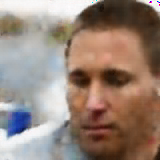

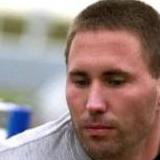

In [ ]:
pre=autoencoder.predict(images[:10]/255.0)
show_image(pre[0]*255.0)
show_image(images[0])

In [ ]:
diff=(images[0:]/255-pred)**2
ms=diff.mean()
import math
print('MS=', ms, ' Root of MS=', math.sqrt(ms))

MS= 0.19931814  Root of MS= 0.4464506028052409
